Import libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import joblib

Reads the data and display the frist 5 rows.

In [2]:
df = pd.read_csv("../../data/Salary_Data.csv")
print("Initial shape:", df.shape)

Initial shape: (6704, 6)


In [3]:
print(df.columns.tolist())

['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience', 'Salary']


In [4]:
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [5]:
df.describe()

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


After loading the dataset I am planning to ready the dataset for the training.\

Let start by data exploration to filter out missing and incorrect data.

In [8]:
print(df.isnull().sum())

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64


Get all duplicate value count

In [10]:
print(df.duplicated().sum())

4912


## Data CLeaning

Remove null values

In [14]:
df.dropna(inplace=True)
print(df.shape)

(6698, 6)


reset the DataFrame index after removing duplicates

In [17]:
df = df.reset_index(drop=True)

Changing inconsistance values to make the cleaning process easy

In [19]:
def clean_text(text):
    if isinstance(text,str):
        text = text.strip().lower()
        text = text.replace("’","'")
        text = text.replace(" degree","")
        text = text.replace("bachelors", "bachelor's")
        text = text.replace("masters", "master's")
        text = text.replace("phd", "phd")
        text = text.title()
    return text

df['Education Level'] = df['Education Level'].apply(clean_text) 

Remove duplicate rows from the DataFrame 

In [21]:
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)
print(df.shape)

(1786, 6)


Removing outliers

In [25]:
Q1 = df['Salary'].quantile(0.25)
Q3 = df['Salary'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#remove unrealistic salaries(salaries that are negative and very low)
df = df[(df['Salary'] >= lower_bound) & (df['Salary'] <= upper_bound) & (df['Salary'] > 1000)]
df = df.reset_index(drop=True)

#summery after cleaning the dataset
print("After removing nulls:", df.shape)
print(df.describe())

After removing nulls: (1782, 6)
               Age  Years of Experience         Salary
count  1782.000000          1782.000000    1782.000000
mean     35.160494             9.175365  113473.068462
std       8.213535             6.844464   51369.548989
min      21.000000             0.000000   25000.000000
25%      29.000000             3.000000   70000.000000
50%      33.000000             8.000000  110353.500000
75%      41.000000            13.000000  160000.000000
max      62.000000            34.000000  250000.000000


Checking if all the null values has been removed

In [26]:
print(df.isnull().sum())

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64


Checking if all the duplicates are removed

In [27]:
print("Duplicates left: ",df.duplicated().sum())

Duplicates left:  0


Check if all the salary outliers have been removed

In [30]:
print("Is all Salary column data higher than 1000?")
print((df['Salary'] > 1000).all())

Is all Salary column data higher than 1000?
True


Lets see a side by side coparison of the dataset before and after the cleaning

In [32]:
# Original dataset
raw_desc = df.describe().T

# Cleaned dataset
cleaned_desc = df.describe().T

# Rename the columns for better understanding
raw_desc.columns = ['Raw_Count', 'Raw_Mean', 'Raw_Std', 'Raw_Min', 'Raw_25%', 'Raw_50%', 'Raw_75%', 'Raw_Max']
cleaned_desc.columns = ['Cleaned_Count', 'Cleaned_Mean', 'Cleaned_Std', 'Cleaned_Min', 'Cleaned_25%', 'Cleaned_50%', 'Cleaned_75%', 'Cleaned_Max']

# Combine side by side to get a clear view 
comparison_df = pd.concat([raw_desc, cleaned_desc], axis=1)

# Display the tables
comparison_df


,Raw_Count,Raw_Mean,Raw_Std,Raw_Min,Raw_25%,Raw_50%,Raw_75%,Raw_Max,Cleaned_Count,Cleaned_Mean,Cleaned_Std,Cleaned_Min,Cleaned_25%,Cleaned_50%,Cleaned_75%,Cleaned_Max
Age,1782.0,35.160494,8.213535,21.0,29.0,33.0,41.0,62.0,1782.0,35.160494,8.213535,21.0,29.0,33.0,41.0,62.0
Years of Experience,1782.0,9.175365,6.844464,0.0,3.0,8.0,13.0,34.0,1782.0,9.175365,6.844464,0.0,3.0,8.0,13.0,34.0
Salary,1782.0,113473.068462,51369.548989,25000.0,70000.0,110353.5,160000.0,250000.0,1782.0,113473.068462,51369.548989,25000.0,70000.0,110353.5,160000.0,250000.0


Nex we are going to scale the data. It is a very important step befor applying Lasso regression.
Why? 
Lasso regression depends on feature magnitude. Scaling ensures fair weight distribution amomg the dataset.

In [33]:
X = df.drop('Salary', axis=1)
y = df['Salary']

Before traing the dataset it is split in 20% and 80%, 80% training the dataset and remaining 20% to do the testing. We do this because we need to train in a idfferent part adn test in another part. Becasue if we do the train and test in the same part of the dataset it will always give very accurate answers which is missleading because the model might have already memorized the answers which leads to overfiting.

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Handle rare Categories

In [35]:
categorical_cols = ['Job Title', 'Education Level']
threshold = 10
for col in categorical_cols:
    top_categories = X_train[col].value_counts().loc[lambda x: x >= threshold].index
    X_train[col] = X_train[col].where(X_train[col].isin(top_categories), 'Other')
    X_test[col] = X_test[col].where(X_test[col].isin(top_categories), 'Other')

In [14]:
#Preprocessing and Pipeline Setup

numeric_cols = ['Age', 'Years of Experience']

#preprocessor: encode categorical features and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

#full pipeline: preprocessing and LassoCV model (automatically finds best alpha)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=5, max_iter=10000, random_state=42))
])

Best alpha: 1.0


So after the Alpha value is found next is t train the model.

In [15]:
#from sklearn.linear_model import Lasso
#from sklearn.metrics import mean_squared_error, r2_score

#lasso = Lasso(alpha=lasso_cv.alpha_)
#lasso.fit(X_train, y_train)

#y_pred = lasso.predict(X_test)

# Evaluate
#mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse:.2f}")
# print(f"R² Score: {r2:.2f}")

Mean Squared Error: 886404808.46
R² Score: 0.66


In [ ]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ---------------------------
# Preprocessing (same as before)
# ---------------------------

numeric_cols = ['Age', 'Years of Experience']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

# ---------------------------
# Pipeline with LassoCV (find best alpha)
# ---------------------------

lasso_cv_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(alphas=np.linspace(0.001, 1, 100), cv=5))
])

# Perform cross-validation
cv_scores = cross_val_score(lasso_cv_model, X_train, y_train, cv=5, scoring='r2')
print("Cross Validation R2 Scores:", cv_scores)
print(f"Mean Cross Validation R2 Score: {cv_scores.mean():.4f}")

# Fit model
lasso_cv_model.fit(X_train, y_train)

# Extract best alpha
best_alpha = lasso_cv_model.named_steps['regressor'].alpha_
print(f"Best alpha from LassoCV: {best_alpha}")

# Training R²
train_r2 = lasso_cv_model.score(X_train, y_train)
print(f"Training R²: {train_r2:.4f}")

# ---------------------------
# Evaluation on Test Data
# ---------------------------

y_pred = lasso_cv_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (Test): {mse:.2f}")
print(f"Test R² Score: {r2:.2f}")


finaly display the results. 

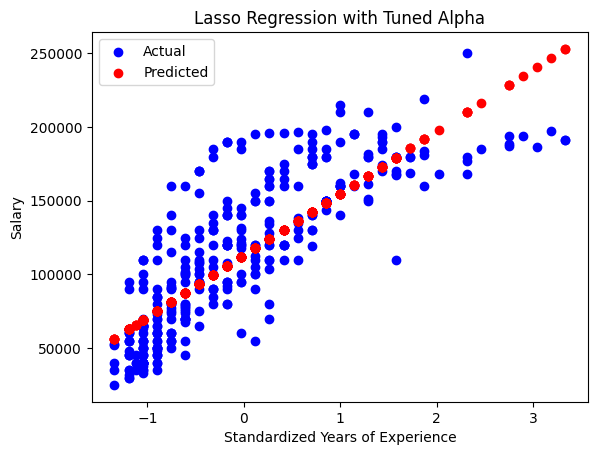

In [16]:
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('Standardized Years of Experience')
plt.ylabel('Salary')
plt.title('Lasso Regression with Tuned Alpha')
plt.legend()
plt.show()

After this I am planning to improve the model more. For this next i'll implement cross-validation. So here data is tested on a deferent subset of the training data. For this purpose I use 5-fold validation which features deviding the dataset into 5 and using one potion for testing and other four for training and this is repeated five times where each portion for testing is only used once.

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

# Use the Alpha value found earlier
lasso = Lasso(alpha=lasso_cv.alpha_)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(lasso, X_scaled, y, cv=5, scoring='r2')

print("Cross-Validation R² scores:", cv_scores)
print("Average R² score:", cv_scores.mean())

Cross-Validation R² scores: [ 0.54348148 -0.20511505  0.23615135  0.71758434  0.75182461]
Average R² score: 0.4087853458969885


Next Residual Analysis is used to identify the differences between the observed values and the predicted values of a model with the purpose of assessing the model's performance and identify potential issues(ex: any consistent errors or patterns) of the model.

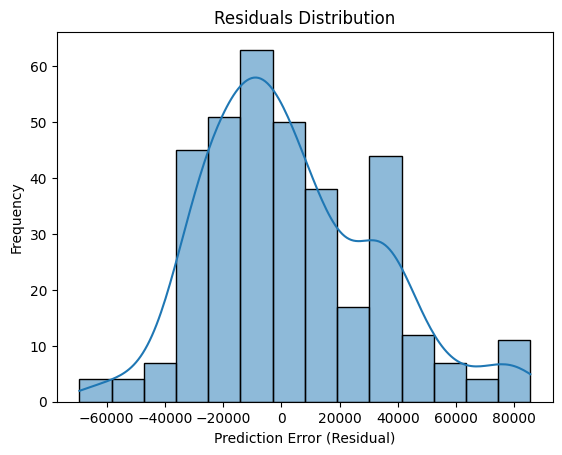

In [18]:
import seaborn as sns

# Calculate residuals (errors)
residuals = y_test - y_pred

# Plot residual distribution
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.show()

What it shows
- Roughly bell shaped. which is good
- It is slightly skewed left: More often overpredicts salary
- Longer tail on the negative side: Some under-predictions.
- There are some outliers (on or after ±75,000)

Conclusion
- Mostly centered which is good but slight skew suggests bias in some salary ranges
- this is in acceptible range but considering the fact that Lasso regression does not consider non-linear relationship this can be improved.

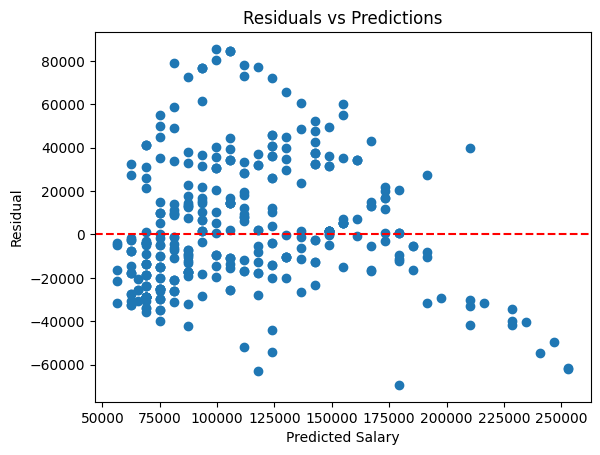

In [19]:

import matplotlib.pyplot as plt

# Scatter residuals vs predicted values
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted Salary")
plt.ylabel("Residual")
plt.show()

What it shows
- Heteroscedasticity: The model’s error increases for higher salaries
- Slight downward slope: Model tends to underpredict high salaries, overpredict low salaries

Conclusion
- Since this model not carture linearity of the data this can't exactly predict correct salary
- Lasso regression is not enought. Should add non-linear models with the comparrison.

Next we will use Grid-search with cross-validation to try multiple alpha values and feature combinations and come up with the more riliable model.
Grid-search: Hyperparameter tuning technique that systematically searches for the best set of hyperparameters for a model by evaluating all possible combinations within a predefined grid.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Build a pipeline: poly features → scale → Lasso
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

# Define grid search parameters
param_grid = {
    'poly__degree': [1, 2],  # Degree 1 (linear), 2 (quadratic)
    'lasso__alpha': [0.001, 0.01, 0.1, 1.0]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'lasso__alpha': 0.001, 'poly__degree': 2}


So now we retrain the model using the Alpha value got from the Grid search. 

In [21]:
# Reuse the best model
model = grid_search.best_estimator_

# Split data again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

Now let's display the last results of our enhanced model.

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Model Mean Squared Error: {mse:.2f}")
print(f"Final Model R² Score: {r2:.2f}")

Final Model Mean Squared Error: 710496290.99
Final Model R² Score: 0.73


Compared to the prvious values

Mean Squared Error: 952897969.69
R² Score: 0.65

new model mean is lower and R² Score is near to 70% which shows that the new model is more reliable than the old one.

Visualizing of the final result

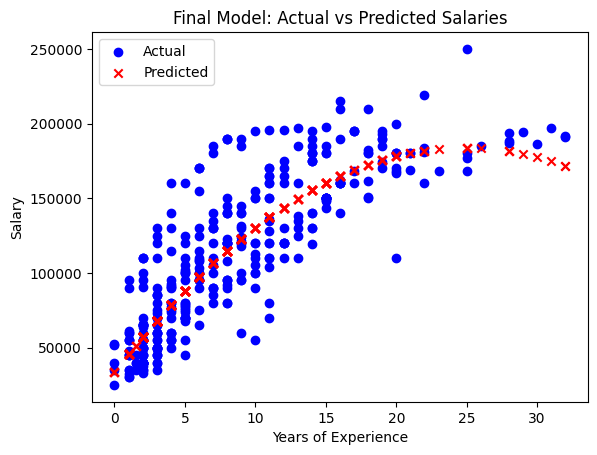

In [23]:
plt.scatter(X_test["Years of Experience"], y_test, color='blue', label='Actual')
plt.scatter(X_test["Years of Experience"], y_pred, color='red', label='Predicted', marker='x')
plt.title("Final Model: Actual vs Predicted Salaries")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.legend()
plt.show()

In [24]:
import joblib

joblib.dump(model, "Lasso_regression.pkl")
print("\nModel saved as Lasso_regression.pkl")


Model saved as Lasso_regression.pkl
